In [1]:
import sys
import os
import json

import numpy as np
from pprint import pprint


nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from recread.receipt.core import read_receipt_from_google_ocr_json

print(sys.version)
pprint(sys.path)

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]
['',
 '/home/viktor/dev/kolonial/ENV/lib/python35.zip',
 '/home/viktor/dev/kolonial/ENV/lib/python3.5',
 '/home/viktor/dev/kolonial/ENV/lib/python3.5/plat-x86_64-linux-gnu',
 '/home/viktor/dev/kolonial/ENV/lib/python3.5/lib-dynload',
 '/usr/lib/python3.5',
 '/usr/lib/python3.5/plat-x86_64-linux-gnu',
 '/home/viktor/dev/kolonial/ENV/lib/python3.5/site-packages',
 '/home/viktor/dev/kolonial/ENV/lib/python3.5/site-packages/IPython/extensions',
 '/home/viktor/.ipython',
 '/home/viktor/dev/recept-scanning']


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.container import Container
from matplotlib.collections import PatchCollection

def plot_annotations(annotations, num_annotations=sys.maxsize):
    full_text_poly = get_plt_poly(annotations[0]['boundingPoly'])
    max_x = max([p[0] for p in full_text_poly])
    max_y = max([p[1] for p in full_text_poly])
    min_x = min([p[0] for p in full_text_poly])
    min_y = min([p[1] for p in full_text_poly])
    fig, ax = plt.subplots(figsize=(max_x/200, max_y/200), dpi=96)
    ax.set_xlim(min(0, min_x), max_x)
    ax.set_ylim(max_y, min(0, min_y))
    ax.xaxis.tick_top()
    patches = []
    num_annotations = min(1000, len(annotations))
    num_sides = 4

    for i in range(0, num_annotations):
        polygon = Polygon(get_plt_poly(annotations[i]['boundingPoly']))
        patches.append(polygon)
    p = PatchCollection(patches)

    colors = 100*np.random.rand(len(patches))
    p.set_array(np.array(colors))

    ax.add_collection(p)
    #plt.show()
    return fig, ax

def get_plt_poly(ocr_poly):
    return [(p['x'] if 'x' in p.keys() else 0, p['y'] if 'y' in p.keys() else 0) for p in ocr_poly['vertices']]



def plot_annotations_with_lines(receipt):
    fig, ax = plot_annotations(receipt.text_annotations)
    overlap_lines = [get_overlap_line(x, receipt.text_annotations) for x in receipt.overlaps if x]
    for line in [Line2D((x[0][0], x[1][0]), (x[0][1], x[1][1]), color='black') for x in overlap_lines]:
        ax.add_line(line)
    plt.show()

In [3]:
def get_left_y_center(ocr_poly):
    return (ocr_poly['vertices'][0]['x'], ocr_poly['vertices'][0]['y'] + abs(ocr_poly['vertices'][3]['y'] - ocr_poly['vertices'][0]['y']) / 2)

def get_right_y_center(ocr_poly):
    return (ocr_poly['vertices'][1]['x'], ocr_poly['vertices'][1]['y'] + abs(ocr_poly['vertices'][2]['y'] - ocr_poly['vertices'][1]['y']) / 2)

def get_overlap_line(overlap, annotations, skip_first=True):
    return (get_left_y_center(annotations[overlap[1 if skip_first and len(overlap) > 1 else 0]]['boundingPoly']), get_right_y_center(annotations[overlap[-1]]['boundingPoly']))
        

In [20]:
import math

def get_x_length(ocr_poly):
    return abs(ocr_poly['vertices'][0]['x'] - ocr_poly['vertices'][1]['x'])

def get_y_length(ocr_poly):
    return abs(ocr_poly['vertices'][0]['y'] - ocr_poly['vertices'][2]['y'])

def get_y_top_diff(ocr_poly):
    return ocr_poly['vertices'][0]['y'] - ocr_poly['vertices'][1]['y']

def tilt_poly_straight(ocr_poly):
    y_length = get_y_length(ocr_poly)
    x_length = get_x_length(ocr_poly)
    
    top_y_diff = get_y_top_diff(ocr_poly)
    
    ocr_poly['vertices'][0]['y'] -= top_y_diff / 2
    ocr_poly['vertices'][1]['y'] += top_y_diff / 2
    ocr_poly['vertices'][2]['y'] += top_y_diff / 2
    ocr_poly['vertices'][3]['y'] -= top_y_diff / 2

def find_skew_angle(ocr_poly):
    left_bottom = ocr_poly['vertices'][3]
    right_bottom = ocr_poly['vertices'][2]
    
    # Do cosine trigonometry
    b = right_bottom['x'] - left_bottom['x']
    c = left_bottom['y'] - right_bottom['y']
    a = math.sqrt(b**2 + c**2)
    
    if left_bottom['y'] < right_bottom['y']:
        return math.acos((a**2 + b**2 - c**2) / (2 * a * b))
    else:
        return -math.acos((a**2 + b**2 - c**2) / (2 * a * b))
    
    
    
def straighten_polys(ocr_polys, angle, center=(0, 0)):
    for poly in ocr_polys:
        rotate_poly(poly, angle, center)
        
def straighten_annotations(annotations):
    angle = get_estimated_skew_angle([x['boundingPoly'] for x in annotations])
    center = (annotations[0]['boundingPoly']['vertices'][0]['x'], annotations[0]['boundingPoly']['vertices'][0]['y'])
    for annotation in annotations:
        rotate_poly(annotation['boundingPoly'], angle, center)
        
        
        
def get_estimated_skew_angle(polys, n=10):
    n_longest = sorted(polys, key=get_x_length, reverse=True)[:min(n, len(polys))]
    result = sum([find_skew_angle(p) for p in n_longest]) / len(n_longest)
    pprint('Skewing')
    pprint(result)
    return result
    

def get_poly_center(ocr_poly):
    return (sum([p['x'] for p in ocr_poly['vertices']]) / 4, sum([p['y'] for p in ocr_poly['vertices']]) / 4)

def rotate_poly(ocr_poly, angle, center=(0, 0)):
    sin = math.sin(angle)
    cos = math.cos(angle)
    ox, oy = center[0], center[1]
    for i, p in enumerate(ocr_poly['vertices']):
        x, y = p['x'], p['y']
        rotated_x = ox + (x - ox) * cos + (y - oy) * sin
        rotated_y = oy - (x - ox) * sin + (y - oy) * cos
        p['x'] = rotated_x + center[0]
        p['y'] = rotated_y + center[1]

def get_straight_poly(ocr_poly, center=(0, 0)):
    return get_rotated_poly(ocr_poly, find_skew_angle(ocr_poly), get_poly_center(ocr_poly))

def get_rotated_poly(ocr_poly, angle, center=(0, 0)):
    sin = math.sin(angle)
    cos = math.cos(angle)
    new_vertices = []
    for i, p in enumerate(ocr_poly['vertices']):
        x = p['x']
        y = p['y']
        centered_x = x - center[0]
        centered_y = y - center[1]
        rotated_x = centered_x * cos - centered_y * sin
        rotated_y = centered_x * sin + centered_y * cos
        result_x = rotated_x + center[0]
        result_y = rotated_y + center[1]
        new_vertices.append(dict(
            x=result_x,
            y=result_y,
        ))
    return {'vertices': new_vertices}


'Skewing'
-0.018893902273408678
READING RECEIPT!!!
[(1, 213), (3, 114), (5, 81), (7, 74), (9, 134)]


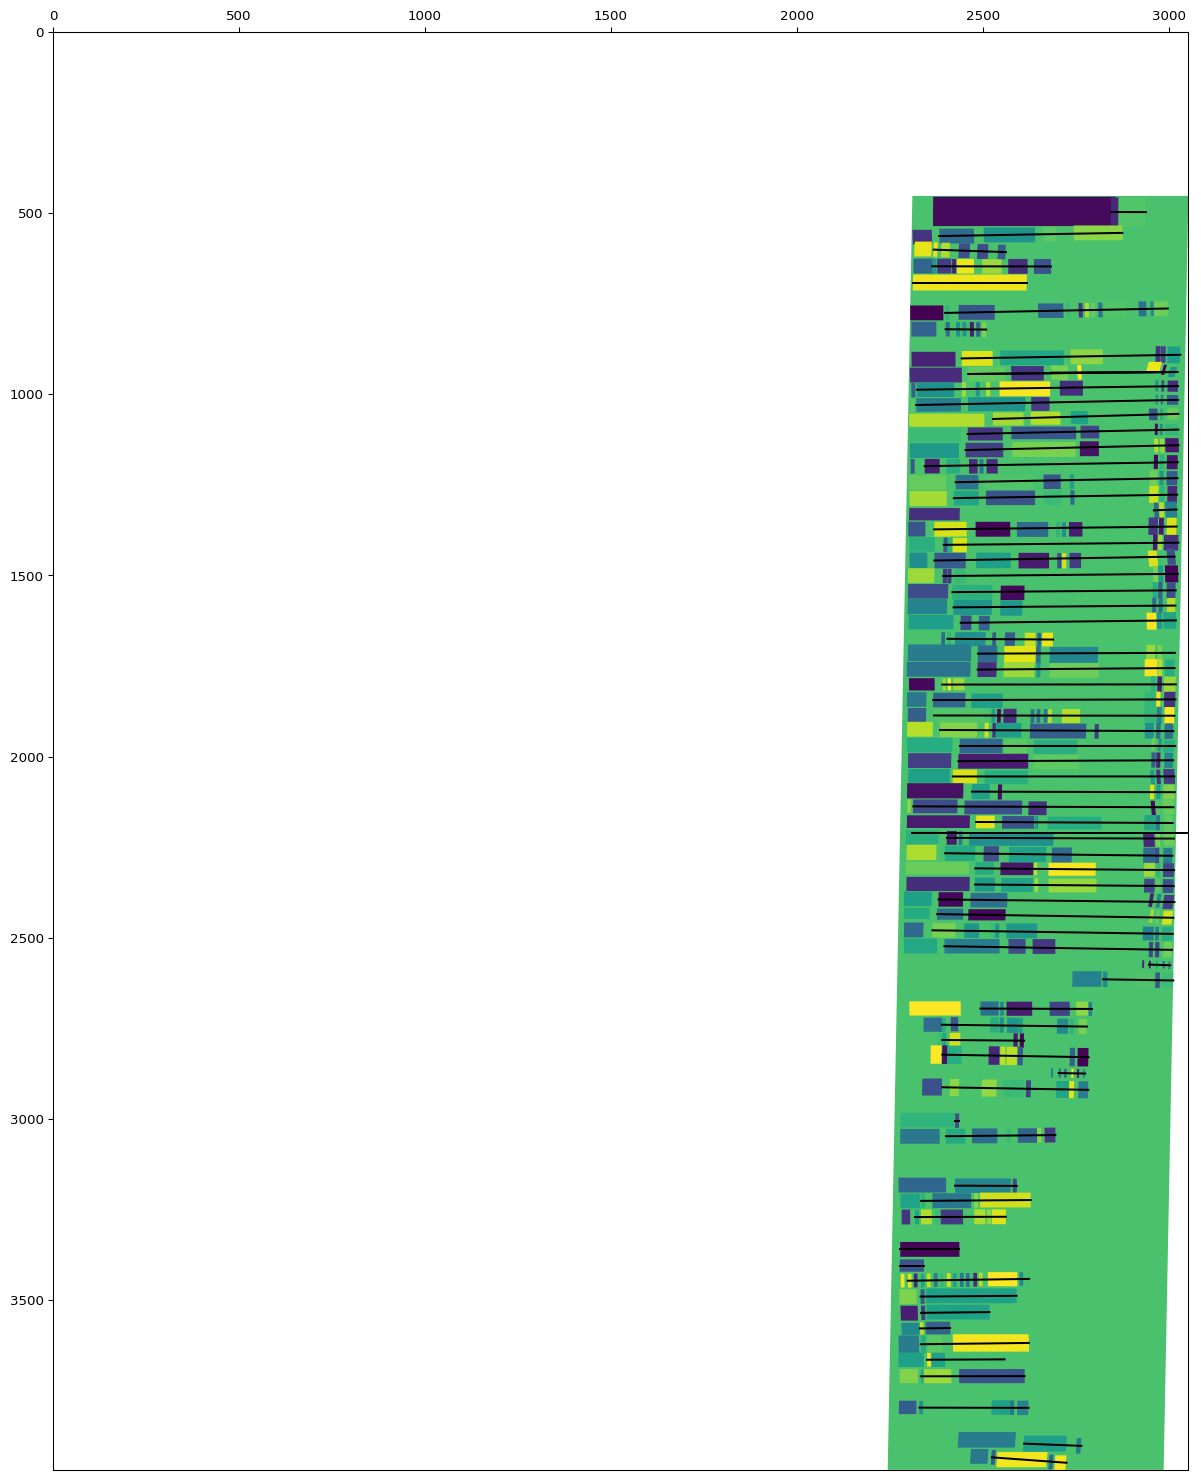

{'products': [{'items_quantity': None,
               'name': 'BondensRiflaPotetchipsChili',
               'price': 9.9,
               'quantity': None,
               'unit_price': None},
              {'items_quantity': None,
               'name': 'Gouda',
               'price': 1.9,
               'quantity': {'unit': 'g', 'value': 450},
               'unit_price': None},
              {'items_quantity': None,
               'name': 'MeierietFyldigGouda',
               'price': 1.9,
               'quantity': {'unit': 'g', 'value': 450},
               'unit_price': None},
              {'items_quantity': None,
               'name': '*SiriusC&amp;LKaramell',
               'price': 9.9,
               'quantity': {'unit': 'g', 'value': 125},
               'unit_price': None},
              {'items_quantity': None,
               'name': '*BlåmuggBurgerost',
               'price': 2.9,
               'quantity': {'unit': 'g', 'value': 80},
               'unit_price': None},

In [31]:
receipt_dir = os.path.join('..', 'data', 'receipt_responses')
file_name = 'receipt_holdbart.json'

with open(os.path.join(receipt_dir, file_name)) as receipt_file:
    receipt_json = json.load(receipt_file)

straighten_annotations(receipt_json['textAnnotations'])
for anno in receipt_json['textAnnotations']:
    tilt_poly_straight(anno['boundingPoly'])
#straighten_annotations(receipt_json['textAnnotations'])

receipt = read_receipt_from_google_ocr_json(receipt_json)

text_annotations = receipt.text_annotations
#for anno in text_annotations:
#    tilt_poly_straight(anno['boundingPoly'])
#straighten_annotations(text_annotations)

plot_annotations_with_lines(receipt)

pprint(receipt.get_json_dict())



In [6]:
poly = text_annotations[-1]['boundingPoly']

print(text_annotations[-1]['description'])
print(find_skew_angle(poly))
pprint(poly)
print(get_poly_center(poly))
pprint(get_rotated_poly(poly, find_skew_angle(poly)))
pprint(get_straight_poly(poly, get_poly_center(poly)))

print(get_estimated_skew_angle([x['boundingPoly'] for x in text_annotations]))


HANDEL
-0.03638708344328837
{'vertices': [{'x': 1638.9603774955708, 'y': 3614.735975087617},
              {'x': 1818.9106139516848, 'y': 3608.1852194526787},
              {'x': 1821.513683525197, 'y': 3678.1653882778214},
              {'x': 1641.5634470690834, 'y': 3684.7161439127603}]}
(1730.237030510384, 3646.4506816827197)
{'vertices': [{'x': 1769.376165992053, 'y': 3552.7194192353995},
              {'x': 1948.9689764540358, 'y': 3539.62658033903},
              {'x': 1954.1161353310702, 'y': 3609.4657294997596},
              {'x': 1774.5233248690874, 'y': 3622.558568396129}]}
{'vertices': [{'x': 1637.8670458408753, 'y': 3618.077526550539},
              {'x': 1817.4598563028583, 'y': 3604.98468765417},
              {'x': 1822.6070151798924, 'y': 3674.8238368148996},
              {'x': 1643.01420471791, 'y': 3687.916675711269}]}
'Skewing'
9.02403152203135e-15
9.02403152203135e-15


In [32]:
for x in receipt.receipt_lines:
    pprint(x.token_line)

['HOLDBART', '.', 'NO']
['Adr', 'Henrik', 'Bullsvei', '115', 'JESSHEIM']
['Tlf', ':', '24', '02', '24', '20']
['Org', '.', 'nr', ':', '816', '664', '582', 'MVA']
['Foretaksregisteret']
['Kvitt',
 ':',
 '111858',
 'Dato',
 ':',
 '6',
 '/',
 '9',
 '/',
 '2018',
 '19',
 ':',
 '47']
['Eksp', ':', 'E', '.', 'H', '.', 'H']
['Bondens', 'Rifla', 'Potetchips', 'Chili', '9', ',', '90']
['Gouda', '450', 'g', '01', '.', '90']
['Meieriet', 'Fyldig', 'Gouda', '450', 'g', '01', '.', '90']
['Meieriet', 'Fyldig', 'Gouda', '450', 'g', '.', '90']
['*', 'Sirius', 'C', '&amp;', 'L', 'Karamell', '125g', '9', ',', '90']
['*', 'Blåmugg', 'Burgerost', '80g', '2', '.', '90']
['Citronpepper', 'Santa', 'Maria', '90g', '14', ',', '90']
['Stimorol', 'senses', 'rainforest', 'min', '7', ',', '50']
['Stimorol', 'senses', 'rainforest', 'min', '7', ',', '50']
['2', 'for', 'kr', '15', ',', '00', '0', ',', '00']
['Odense', 'Ekte', 'Marsipan', '400', 'g', '19', ',', '90']
['Odense', 'Ekte', 'Marsipan', '400', 'g', '19', ',